# Box Office Mojo
Scrapes `Box Office Mojo` by IMDB Pro, using BeautifulSoup, for the various tables. The website tracks box office revenue in a "systematic, algorithmic way", and contains the box office for many countries, and contains specific information on the each release. 

#### Import libraries for webscraping 

In [409]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

#### Import Libraries for cleaning the data and for graphing

In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [502]:
base_url = "https://www.boxofficemojo.com/weekend/by-year/"
years = ["2024", "2023", "2022", "2021", "2020"]

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Language": "en-US,en;q=0.9"
}

all_data = [] 

In [415]:
for year in years:
    url = f"{base_url}{year}/" # build the URL for the current year based on pattern
    print(f"Scraping {url}") # making sure the website is neing scraped through output checl
    response = requests.get(url, headers=headers)

    # check if the request is successful
    if response.status_code != 200:
        print(f"Failed to load {url}")
        continue

    # parse the page content
    soup = BeautifulSoup(response.text, "html.parser")

    # find the box office table
    table = soup.find("table")
    if not table: # print error message if needed
        print(f"No table found for {year}")
        continue

    rows = table.find_all("tr")[1:]  # find all of the rows in HTML table, but skip the header

    for row in rows:
        cols = row.find_all("td") # find each of the elements (weekend, date, movie title, etc)
        if len(cols) >= 7:
            weekend = cols[0].text.strip() # strip the whitepace around it for all (first col)
            movie = cols[2].text.strip() # third column
            weekend_gross = cols[1].text.strip() # second column 
            theaters = cols[4].text.strip() # fifth column 
            total_gross = cols[6].text.strip() # seventh column 

            # append to the 'all_data' dictionary created prior to scraping 
            all_data.append({
                "Year": year,
                "Weekend": weekend,
                "Movie": movie,
                "Weekend Gross": weekend_gross,
                "Theaters": theaters,
                "Total Gross to Date": total_gross
            })

Scraping https://www.boxofficemojo.com/weekend/by-year/2024/
Scraping https://www.boxofficemojo.com/weekend/by-year/2023/
Scraping https://www.boxofficemojo.com/weekend/by-year/2022/
Scraping https://www.boxofficemojo.com/weekend/by-year/2021/
Scraping https://www.boxofficemojo.com/weekend/by-year/2020/


### Data Collection 
##### Store the scraped data in a dataframe `df`
##### Save the dataframe in a csv file, to clean and to view structures of dates, movies etc...

In [417]:
df = pd.DataFrame(all_data)
df.to_csv("box_office_weekend_data.csv", index=False)
df.head()

,Year,Weekend,Movie,Weekend Gross,Theaters,Total Gross to Date
0,2024,Dec 27-29,+13.9%,"$159,403,178",+20.5%,Sonic the Hedgehog 3
1,2024,Dec 20-22,+59.8%,"$139,944,015",+50.9%,Sonic the Hedgehog 3
2,2024,Dec 13-15,-32.4%,"$87,557,182",-31.4%,Moana 2
3,2024,Dec 6-8Post-Thanksgiving,-52.9%,"$129,558,686",-50.4%,Moana 2
4,2024,Nov 29-Dec 1Thanksgiving 3-Day,+37.6%,"$274,782,835",+36.7%,Moana 2


### Cleaning the Data

1. **Mismatched column names:**
   - Total Gross to Date is attatched to the movies names  
   - Percent Increases are mismatched
   - Column Names are also vague and misleading

In [419]:
df = df.rename(columns={
    'Weekend Gross': 'Weekend Gross ($)',
    'Gross Change (%)': 'Movie',
    'Theaters': 'Theaters Change (%)',
    'Total Gross to Date': 'Movie'
})

2. **Change Data Type**
   - Change the weekend grosss to be numerical
3. **Change Formatting of the Date**
   - Add a space between the date and special holidays, for easie cleaning.

1. In the code below, I used a regular expression/regex to clean the text, so the numbers with commas become numeric strings
2. After the values become digits, I convert the string to floats, so I can perform calculations on the numbers if needed

In [421]:
df['Weekend Gross ($)'] = df['Weekend Gross ($)'].replace('[\$,]', '', regex=True).astype(float)

1. First, I added a space if a number is "squished" right next to a letter
   - '15Dec' become '15 Dec'
2. In the regex, the pattern `r'(\d)([A-Za-z])` breaks down to
   - (\d) &rarr; matched a digit 0-9
   - ([A-Za-z])&rarr; matches a letter, lowercase or uppercare
3. The replacement `r'\1 \2`
   - \1 &rarr; digit that is matched
   - \2 &rarr; refers to the letter
   - Space is added, format is cleaner now for stripping down the days

In [423]:
df['Weekend'] = df['Weekend'].apply(lambda x: re.sub(r'(\d)([A-Za-z])', r'\1 \2', x))
df[['Weekend']]

,Weekend
0,Dec 27-29
1,Dec 20-22
2,Dec 13-15
3,Dec 6-8 Post-Thanksgiving
4,Nov 29-Dec 1 Thanksgiving 3-Day
...,...
303,Jan 24-26
304,Jan 17-20 MLK wknd
305,Jan 17-19
306,Jan 10-12


### Data Cleaning
- I created a list, to save each of the holiday labels/regex patterns as a string. Initially, I wanted to create a loop to interate through the date column and seperate out the holidays/ special days, but I realized there was not much of a pattern, and decided to just manually write out the holidays. 
- After cleaning, some of the days did not seperate irregardless of changing up the extraction code, so I decided to continue on. 


In [425]:
holiday_keywords = [
    'COVID-19 Pandemic',
    'COVID-19 PandemicEaster wknd',
    "COVID-19 PandemicIndig. Peoples' Day wknd",
    'COVID-19 PandemicLabor Day wknd',
    'COVID-19 PandemicMLK wknd',
    'COVID-19 PandemicMemorial Day wknd',
    'COVID-19 PandemicPost-Thanksgiving',
    "COVID-19 PandemicPresidents' Day wknd",
    'COVID-19 PandemicThanksgiving 3-Day',
    'COVID-19 PandemicThanksgiving 4-Day',
    'COVID-19 PandemicThanksgiving 5-Day',
    'Christmas long wknd',
    'Easter wknd',
    "Indig. Peoples' Day wknd",
    'July 4th long wknd',
    'Labor Day wknd',
    'MLK wknd',
    'Memorial Day wknd',
    'Post-Thanksgiving',
    'Post-ThanksgivingWorld Cup (Qatar)',
    "Presidents' Day wknd",
    'Thanksgiving 3-Day',
    'Thanksgiving 3-DayWorld Cup (Qatar)',
    'Thanksgiving 4-Day',
    'Thanksgiving 4-DayWorld Cup (Qatar)',
    'Thanksgiving 5-Day',
    'Thanksgiving 5-DayWorld Cup (Qatar)',
    'World Cup (Qatar)',
    "New Year's long wknd"
]

In [427]:
 # Join all of the event keywords into a single regex pattern, using the "|"
holiday_pattern = "|".join(holiday_keywords)

# Define a function to extract the special days  
def extract_special_day(weekend):
    # Look for any holiday/event keyword match within the weekend string
    match = re.search(holiday_pattern, weekend)
    
    if match:
        # Remove the matched keyword from the string to clean up the weekend date
        clean_weekend = re.sub(holiday_pattern, "", weekend).strip()
        special_day = match.group()
        return pd.Series([clean_weekend, special_day])
        
    # If no match is found, return the original weekend string and None for special day
    return pd.Series([weekend.strip(), None])

# Apply the function to the 'Weekend' column and split results into 'Weekend' and 'Special Days' columns
df[["Weekend", "Special Days"]] = df["Weekend"].apply(extract_special_day)

# Save the cleaned DataFrame to a new CSV file
df.to_csv("cleaned_box_office_data.csv", index=False)

# Pint the first few cleaned rows of the weekend & special day column to confirm if it worked
print(df[["Weekend", "Special Days"]].head())



        Weekend        Special Days
0     Dec 27-29                None
1     Dec 20-22                None
2     Dec 13-15                None
3       Dec 6-8   Post-Thanksgiving
4  Nov 29-Dec 1  Thanksgiving 3-Day


# Analysis & Questions


### 1. Which year had the highest total weekend box office revenue?

> I first made sure that the 'Weekend Gross' Column was indeed numeric, so then I could plot the box office by year and see the amount of money by weekedn in each year. 
> I then created a variable, yearly totals, which: 
>> Groups the data by each year (2020-2024)
>> Focuses on the weekend gross amount
>> Calculates the total gross per year
>> Converts the result back into a df, with regualr int. index
>>
>> For the bar labels, a resource was used:
>>> https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot


In [429]:
# Convert the 'Weekend Gross ($)' column to numeric 
df['Weekend Gross ($)'] = pd.to_numeric(df['Weekend Gross ($)'], errors='coerce') 

# Group the data by year and calculate the total weekend gross per year
yearly_totals = df.groupby('Year')['Weekend Gross ($)'].sum().reset_index()


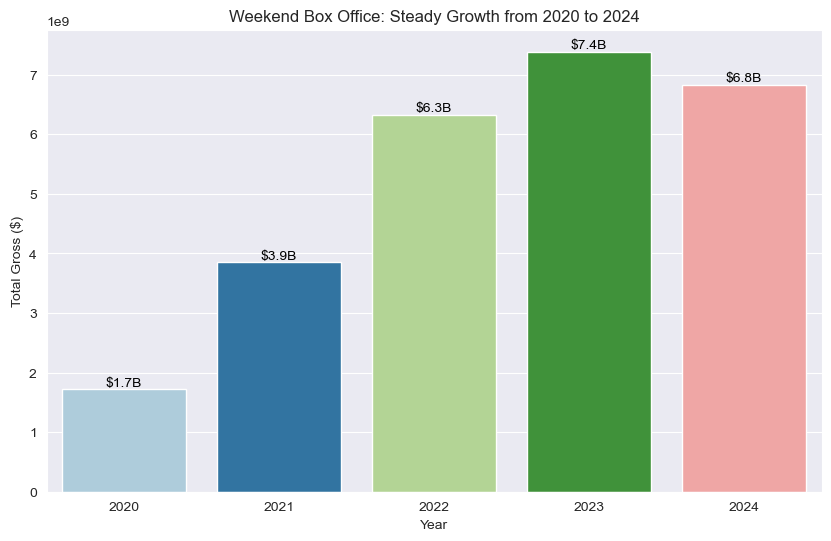

In [437]:
plt.figure(figsize=(10,6)) # Set up the figure size and plot style

sns.set_style("darkgrid") # darker grid style

# Create a bar plot showing total weekend grosses per year using seabon
ax = sns.barplot(data=yearly_totals, x='Year', y='Weekend Gross ($)', hue='Year', palette="Paired", legend=False)

# add dollar labels on each plot showing the total weekend grosses per year (stackoverflow + w3schools for help)
for index, row in yearly_totals.iterrows():
    billions = row['Weekend Gross ($)'] / 1e9
    ax.text(index, row['Weekend Gross ($)'], f'${billions:.1f}B',
            color='black', ha='center', va='bottom', fontsize=10)

# Add a title and axis labels
plt.title('Weekend Box Office: Steady Growth from 2020 to 2024')
plt.ylabel('Total Gross ($)')
plt.xlabel('Year')

# show final graph
plt.show()


### 2. Which movie had the highest-grossing opening weekend in each year?

##### Find the movie with the highest-grossing weekend in each year
##### Group by 'Year', find the index of the max 'Weekend Gross ($)', and use .loc to extract those rows

In [378]:
high_gross_movie_per_year = df.loc[df.groupby("Year")["Weekend Gross ($)"].idxmax()] 

In [444]:
high_gross_movie_per_year = high_gross_movie_per_year[["Year", "Weekend", "Movie", "Weekend Gross ($)"]] #select only relevant columns 

high_gross_movie_per_year

,Year,Weekend,Movie,Movie,Weekend Gross ($)
304,2020,Jan 17-20 MLK wknd,-,Bad Boys for Life,182673454.0
188,2021,Dec 17-19,+591.1%,Spider-Man: No Way Home,281737588.0
154,2022,Jul 8-10,+25.9%,Thor: Love and Thunder,237265821.0
89,2023,Jul 21-23,+129.4%,Barbie,307805201.0
6,2024,Nov 27-Dec 1 Thanksgiving 5-Day,-,Moana 2,421199078.0


### 3. How do weekend grosses change seasonally (e.g., summer vs winter)?

> - First, the month abbreviation must be stripped from the date name 
> - Second, a dictionary must be created, mapping the months to the seasons
> Then, I created a new column named 'season' in the dataframe for graphing

In [456]:
df["Month"] = df["Weekend"].str.extract(r'([A-Za-z]+)') #Extract the month abbreviation

In [122]:
# Create a dictionary mapping month to season
month_season = {
    "Dec": "Winter", "Jan": "Winter", "Feb": "Winter", 
    "Mar": "Spring", "Apr": "Spring", "May": "Spring", 
    "Jun": "Summer", "Jul": "Summer", "Aug": "Summer", 
    "Sep": "Fall", "Oct": "Fall", "Nov": "Fall",
}

In [124]:
df["Season"] = df["Month"].map(month_season) # apply mapping 

> Now, group by season & calculate the average weekend grosses

In [133]:
# group by season & calculate average wknd gross
seasonal_avg = df.groupby("Season")["Weekend Gross ($)"].mean().reset_index()

In [135]:
# I ordered the seasons in calendar order (for coherent visuals)
season_order = ["Winter", "Spring", "Summer", "Fall"]
seasonal_avg["Season"] = pd.Categorical(seasonal_avg["Season"], categories=season_order, ordered=True)
seasonal_avg = seasonal_avg.sort_values("Season")

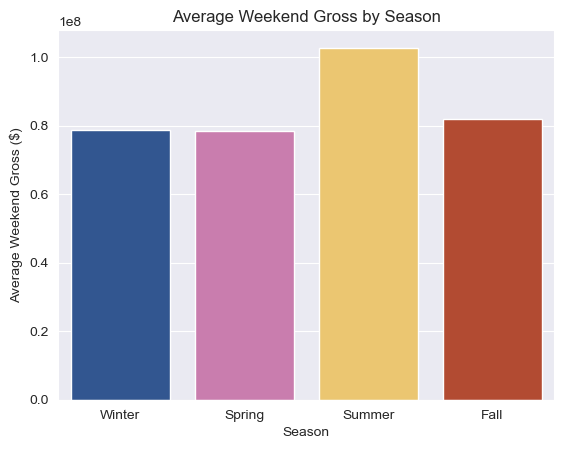

In [458]:
palette = ["#23529F", "#D571B2", "#FFCE5D", "#C73E1D"] #custom palete for seasons (easier to differentiate)

#seaborn plot showing average weekend gross by season
sns.barplot(data=seasonal_avg, x="Season", y="Weekend Gross ($)", hue='Season', palette=palette, legend=False)

# Add labels & title
plt.xlabel("Season")
plt.ylabel("Average Weekend Gross ($)")
plt.title("Average Weekend Gross by Season")

# Final graph
plt.show()

#### 4. Which months have the highest concentration of movie releases?

> To answer this question, I needed to understand how box office revenue shifts throughout the year, specifically by season. I realized a heatmap would be the best for this question, as it would let me spot what year was the most + color shading makes identifying easier. 
>> I first extracted the month from each weekend label using a regular expression.
>> - Then I created a mapping dictionary to assign each month to its corresponding season (e.g., Jul → Summer).
>> - I added a new column called "Season" to the dataset based on that mapping.

>Finally, I grouped the data by "Season" and calculated the average weekend gross for each one, which I visualized with a colored bar chart.

##### Used for ploting: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [221]:
# Group by Year and Month to count how many movies were released in each month of each year
monthly_trend = df.groupby(["Year", "Month"]).size().reset_index(name="Releases")

In [265]:
# Define the order of months to appear correctly on the heatmap
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Make sure the Month column is treated as a categorical variable with the right order
monthly_trend["Month"] = pd.Categorical(monthly_trend["Month"], categories=month_order, ordered=True)

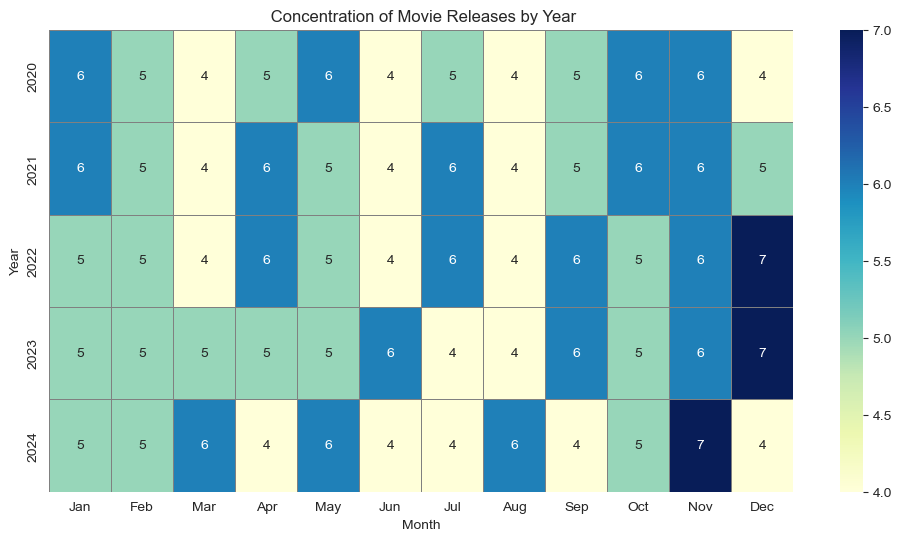

In [473]:
# Pivot the data to create a heatmap matrix
heatmap_data = monthly_trend.pivot(index="Year", columns="Month", values="Releases")

plt.figure(figsize=(12, 6)) # set figure size
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title(" Concentration of Movie Releases by Year")
plt.xlabel("Month")
plt.ylabel("Year")

# final graph
plt.show()

## Final Summary of Findings

1. Which year had the highest total weekend box office revenue?
   - The data show a steady growth in weekend box offices form 2020 to 2024.
   - 2023 is recorded as the highest total, showing upward growth and string post-pandemic recovery


2. Which movie had the highest-grossing opening weekend in each year?


| Year   | Movie |
| :----| -----------: |
| 2020 |Bad Boys for Life |
| 2021 | Spider-Man: No Way Home|
| 2022    | Thor: Love & Thunder|
| 2023   | Barbie |
| 2024   | Moana 2   |

3. How do weekend grosses change seasonally (e.g., summer vs winter)?
   - Summer consistently brought in the highest average weekend grosses, likely due to blockbuster releases.
   - Winter followed closely, boosted by holiday films.
   - Spring and Fall showed lower average grosses, with fewer major releases.

4. Which months have the highest concentration of movie releases?
   - The summer months (June–August) and holiday-heavy months (November–December) saw the most releases &rarr; more people are likely to be on vacation or break
   - A heatmap visualization clearly highlighted this seasonal trend over the years.